In [1]:
#!/usr/bin/env python
# coding: utf-8
# Imports
import pandas as pd
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score, matthews_corrcoef
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
import torchvision
from sklearn.preprocessing import normalize

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data

In [3]:
###############################
###    Load data            ###
###############################

data_list = []
target_list = []

for fp in glob.glob("/home/ida/train_data/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    
    data_list.append(data)
    target_list.append(targets)

## Model

In [4]:
###############################
###    Define network       ###
###############################

print("Initializing network")

# Hyperparameters
input_size = 420
num_classes = 1
learning_rate = 0.001
bat_size = 128
n_features = 54
criterion = nn.BCEWithLogitsLoss()
class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()
        self.bn0 = nn.BatchNorm1d(n_features)    
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(100)
        
        self.rnn = nn.LSTM(input_size=100,hidden_size=26,num_layers=3, dropout=0.1, batch_first=True, bidirectional = True)
        self.drop = nn.Dropout(p = 0.1)

        self.fc1 = nn.Linear(26*2, num_classes)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.bn0(x)  
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = self.drop(x)
        x = x.transpose_(2, 1)
        x, (h, c) = self.rnn(x)
        cat = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
        cat = self.drop(cat)
        x = self.fc1(cat)
        return x

Initializing network


In [5]:
# Weighted loss function from one of the hackathon teams
def weighted_binary_cross_entropy(output, target, weights=None):
    if weights is not None:
        assert len(weights) == 2
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)
    return torch.neg(torch.mean(loss))

## Train function

In [6]:
###############################
###         TRAIN           ###
###############################

def train(train_ldr, val_ldr, test_ldr):

    num_epochs = 100

    train_acc = []
    valid_acc = []
    train_losses = []
    valid_losses = []
    train_auc = []
    valid_auc = []

    no_epoch_improve = 0
    min_val_loss = np.Inf
    
    test_probs, test_preds, test_targs = [], [], []

    for epoch in range(num_epochs):
        cur_loss = 0
        val_loss = 0
        # Train
        net.train()
        train_preds, train_targs, train_probs = [], [], []
        for batch_idx, (data, target) in enumerate(train_ldr):
            X_batch =  data.float().detach().requires_grad_(True)
            target_batch = torch.tensor(np.array(target), dtype = torch.float).unsqueeze(1)

            optimizer.zero_grad()
            output = net(X_batch)

            #batch_loss = weighted_binary_cross_entropy(output, target_batch, [0.75,0.25])
            batch_loss = criterion(output, target_batch)
            batch_loss.backward()
            optimizer.step()
      
            probs = torch.sigmoid(output.detach())
            preds = np.round(probs)
            train_probs += list(probs.data.numpy())
            train_targs += list(np.array(target_batch))
            train_preds += list(preds.data.numpy())
            cur_loss += batch_loss.detach()

        train_losses.append(cur_loss / len(train_ldr.dataset))        

        net.eval()
        # Validation
        val_preds, val_targs, val_probs = [], [], []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_ldr):
                x_batch_val = data.float().detach()
                y_batch_val = target.float().detach().unsqueeze(1)

                output = net(x_batch_val)
                val_batch_loss = criterion(output, y_batch_val)

                probs = torch.sigmoid(output.detach())
                preds = np.round(probs)
                val_probs += list(probs.data.numpy())
                val_preds += list(preds.data.numpy()) 
                val_targs += list(np.array(y_batch_val))
                val_loss += val_batch_loss.detach()

            valid_losses.append(val_loss / len(val_ldr.dataset))
            print("\nEpoch:", epoch+1)

            train_acc_cur = accuracy_score(train_targs, train_preds)  
            valid_acc_cur = accuracy_score(val_targs, val_preds) 
            train_auc_cur = roc_auc_score(train_targs, train_probs)
            valid_auc_cur = roc_auc_score(val_targs, val_probs)

            train_acc.append(train_acc_cur)
            valid_acc.append(valid_acc_cur)
            train_auc.append(train_auc_cur)
            valid_auc.append(valid_auc_cur)

            print("Training loss:", train_losses[-1].item(), "Validation loss:", valid_losses[-1].item(), end = "\n")
            print("MCC Train:", matthews_corrcoef(train_targs, train_preds), "MCC val:", matthews_corrcoef(val_targs, val_preds))
            print("AUC Train:", train_auc_cur, "AUC val:", valid_auc_cur)
            print("Confusion train:")
            print(confusion_matrix(train_targs, train_preds))
            print("Confusion validation:")
            print(confusion_matrix(val_targs, val_preds))

        # Early stopping
        if (val_loss / len(X_valid)).item() < min_val_loss:
            no_epoch_improve = 0
            min_val_loss = (val_loss / len(X_valid))
        else:
            no_epoch_improve +=1
        if no_epoch_improve == 5:
            print("Early stopping\n")
            break
            
    # Test
    if test_ldr is not None:
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_ldr): ###
                x_batch_test = data.float().detach()
                y_batch_test = target.float().detach().unsqueeze(1)

                output = net(x_batch_test)

                #test_batch_loss = criterion(output, y_batch_test)
                probs = torch.sigmoid(output.detach())
                preds = np.round(probs)
                test_probs += list(probs.data.numpy())
                test_preds += list(preds.data.numpy())
                test_targs += list(np.array(y_batch_test))

    return train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, test_probs, test_preds, test_targs

## Nested cross-validation

In [7]:
# Nested cross validation

test_probs_all = [None] * 20
test_preds_all = [None] * 20
test_targs_all = [None] * 20

run_count = 1
for i in range(5):
    
    # Test set
    X_test = data_list[i]
    y_test = target_list[i]
    test_ds = []
    for k in range(len(X_test)):
        test_ds.append([np.transpose(X_test[k][:,:]), y_test[k]])
    test_ldr = torch.utils.data.DataLoader(test_ds,batch_size=bat_size, shuffle=True)

    X_remaining = data_list[:i] + data_list[i+1:]
    y_remaining = target_list[:i] + target_list[i+1:]

    for j in range(4):
        
        print(f"Run {run_count}. Testing on partition {i+1}.")
        
        # Validation set
        X_valid = X_remaining[j]
        y_valid = y_remaining[j]
        valid_ds = []
        for k in range(len(X_valid)):
            valid_ds.append([np.transpose(X_valid[k][:,:]), y_valid[k]])
        valid_ldr = torch.utils.data.DataLoader(valid_ds,batch_size=bat_size, shuffle=True)
        
        # Train set
        X_train = np.concatenate(X_remaining[:j] + X_remaining[j+1:])
        y_train = np.concatenate(y_remaining[:j] + y_remaining[j+1:])
        train_ds = []
        for k in range(len(X_train)):
            train_ds.append([np.transpose(X_train[k][:,:]), y_train[k]])
        train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
            
        # Initialize network
        net = Net(num_classes=num_classes).to(device)

        # Optimizer
        optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                       weight_decay=0.0005,
                       amsgrad=True,
                       )
        #optim.SGD(net.parameters(), lr=learning_rate)
        # Train
        _, _, _, _, _, _, test_probs, test_preds, test_targs = train(train_ldr, valid_ldr, test_ldr)
        test_probs_all[run_count] = test_probs
        test_preds_all[run_count] = test_preds
        test_targs_all[run_count] = test_targs
        
        run_count += 1

Run 1. Testing on partition 1.

Epoch: 1
Training loss: 0.00451744394376874 Validation loss: 0.004101337864995003
MCC Train: 0.0 MCC val: 0.0
AUC Train: 0.5514612732184506 AUC val: 0.6901717644897585
Confusion train:
[[2931    0]
 [ 976    0]]
Confusion validation:
[[1146    0]
 [ 380    0]]


/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.004071464762091637 Validation loss: 0.0038727486971765757
MCC Train: 0.1674242492239022 MCC val: 0.3891174390987592
AUC Train: 0.6979689274068606 AUC val: 0.737730779829154
Confusion train:
[[2907   24]
 [ 912   64]]
Confusion validation:
[[1024  122]
 [ 204  176]]

Epoch: 3
Training loss: 0.003832054790109396 Validation loss: 0.0036235980223864317
MCC Train: 0.3575501868094034 MCC val: 0.4322903837997231
AUC Train: 0.7390301385416492 AUC val: 0.7596973454578856
Confusion train:
[[2770  161]
 [ 658  318]]
Confusion validation:
[[1065   81]
 [ 213  167]]

Epoch: 4
Training loss: 0.0036041110288351774 Validation loss: 0.003589425701647997
MCC Train: 0.4375319379062883 MCC val: 0.4342544229905128
AUC Train: 0.7667776202381552 AUC val: 0.7687563148709469
Confusion train:
[[2759  172]
 [ 568  408]]
Confusion validation:
[[1099   47]
 [ 239  141]]

Epoch: 5
Training loss: 0.0034685947466641665 Validation loss: 0.0034666662104427814
MCC Train: 0.4662156211227659 MCC

/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.004129339940845966 Validation loss: 0.0038795415312051773
MCC Train: 0.14104839027270466 MCC val: 0.35582798315106007
AUC Train: 0.684863233534952 AUC val: 0.7323021267216129
Confusion train:
[[2890   38]
 [ 910   63]]
Confusion validation:
[[1082   67]
 [ 256  127]]

Epoch: 3
Training loss: 0.003927972167730331 Validation loss: 0.0036404684651643038
MCC Train: 0.3209236736569995 MCC val: 0.47795409711714765
AUC Train: 0.7229415530807204 AUC val: 0.7517014454617138
Confusion train:
[[2772  156]
 [ 694  279]]
Confusion validation:
[[1125   24]
 [ 245  138]]

Epoch: 4
Training loss: 0.0037416573613882065 Validation loss: 0.00351309753023088
MCC Train: 0.4106879110977085 MCC val: 0.467007263692805
AUC Train: 0.7504910591433176 AUC val: 0.7673058875125833
Confusion train:
[[2780  148]
 [ 613  360]]
Confusion validation:
[[1068   81]
 [ 200  183]]

Epoch: 5
Training loss: 0.003536664880812168 Validation loss: 0.0032993515487760305
MCC Train: 0.4725941931860848 MCC


Epoch: 14
Training loss: 0.0022307352628558874 Validation loss: 0.00358998728916049
MCC Train: 0.7128994039360174 MCC val: 0.5330016633916603
AUC Train: 0.9136938576943597 AUC val: 0.802615270657778
Confusion train:
[[3102   69]
 [ 365  690]]
Confusion validation:
[[850  56]
 [140 161]]

Epoch: 15
Training loss: 0.0020121526904404163 Validation loss: 0.003939824178814888
MCC Train: 0.7359672652955128 MCC val: 0.5350429676435505
AUC Train: 0.9295083853823378 AUC val: 0.8009321393735378
Confusion train:
[[3084   87]
 [ 314  741]]
Confusion validation:
[[863  43]
 [150 151]]

Epoch: 16
Training loss: 0.002003890462219715 Validation loss: 0.0038794376887381077
MCC Train: 0.7407609343818975 MCC val: 0.5302568907737009
AUC Train: 0.9282400785555112 AUC val: 0.7977785600610181
Confusion train:
[[3090   81]
 [ 313  742]]
Confusion validation:
[[855  51]
 [145 156]]

Epoch: 17
Training loss: 0.0017495970241725445 Validation loss: 0.00391746498644352
MCC Train: 0.7867392207278462 MCC val: 0.537

/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.0040161083452403545 Validation loss: 0.004332673270255327
MCC Train: 0.2356828057339803 MCC val: 0.30966808874170915
AUC Train: 0.710873951514212 AUC val: 0.7173054669418903
Confusion train:
[[3102   99]
 [ 889  175]]
Confusion validation:
[[826  50]
 [209  83]]

Epoch: 3
Training loss: 0.0037875305861234665 Validation loss: 0.004245081916451454
MCC Train: 0.3741807510358882 MCC val: 0.40797551526137604
AUC Train: 0.7458738810475111 AUC val: 0.7339713517232751
Confusion train:
[[3049  152]
 [ 718  346]]
Confusion validation:
[[812  64]
 [170 122]]

Epoch: 4
Training loss: 0.003592275083065033 Validation loss: 0.0042226798832416534
MCC Train: 0.45551835162060994 MCC val: 0.4176070930906296
AUC Train: 0.7685952815497037 AUC val: 0.7481860261462439
Confusion train:
[[3022  179]
 [ 605  459]]
Confusion validation:
[[796  80]
 [156 136]]

Epoch: 5
Training loss: 0.003361043520271778 Validation loss: 0.003935227170586586
MCC Train: 0.4963028112307076 MCC val: 0.442

/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.004153152462095022 Validation loss: 0.003977632615715265
MCC Train: 0.08097505848736464 MCC val: 0.3231528059706172
AUC Train: 0.6815588802009049 AUC val: 0.7399293888483077
Confusion train:
[[2921   10]
 [ 957   19]]
Confusion validation:
[[1060   50]
 [ 270  100]]

Epoch: 3
Training loss: 0.003829187247902155 Validation loss: 0.003819771809503436
MCC Train: 0.34410954813443645 MCC val: 0.42007295519638654
AUC Train: 0.7392626027037155 AUC val: 0.7607572437302168
Confusion train:
[[2790  141]
 [ 686  290]]
Confusion validation:
[[1047   63]
 [ 224  146]]

Epoch: 4
Training loss: 0.0036010784097015858 Validation loss: 0.003702818648889661
MCC Train: 0.4484555164813927 MCC val: 0.44082967047464955
AUC Train: 0.766716445458664 AUC val: 0.7646944241538837
Confusion train:
[[2747  184]
 [ 547  429]]
Confusion validation:
[[1037   73]
 [ 208  162]]

Epoch: 5
Training loss: 0.00344349374063313 Validation loss: 0.003590964013710618
MCC Train: 0.4763263573006361 MCC 

/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.004221287555992603 Validation loss: 0.003864337457343936
MCC Train: 0.11537920021852746 MCC val: 0.339085266498727
AUC Train: 0.6781765575246786 AUC val: 0.7362992453421866
Confusion train:
[[2890    2]
 [ 943   20]]
Confusion validation:
[[1132   17]
 [ 305   78]]

Epoch: 3
Training loss: 0.0039847176522016525 Validation loss: 0.0036327627021819353
MCC Train: 0.3229461400625312 MCC val: 0.4480713973679698
AUC Train: 0.7379303237778437 AUC val: 0.7491972813230713
Confusion train:
[[2750  142]
 [ 694  269]]
Confusion validation:
[[1105   44]
 [ 238  145]]

Epoch: 4
Training loss: 0.0037354242522269487 Validation loss: 0.0035792465787380934
MCC Train: 0.4187742487416223 MCC val: 0.4611223636268829
AUC Train: 0.7671809941558264 AUC val: 0.7568529337578143
Confusion train:
[[2755  137]
 [ 606  357]]
Confusion validation:
[[1094   55]
 [ 223  160]]

Epoch: 5
Training loss: 0.0035707580391317606 Validation loss: 0.003505959175527096
MCC Train: 0.46582011157366154 M

/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.004046514630317688 Validation loss: 0.004299381747841835
MCC Train: 0.20056278778510556 MCC val: 0.18306258818435467
AUC Train: 0.6988254237158795 AUC val: 0.6701062682889266
Confusion train:
[[3100   35]
 [ 949   96]]
Confusion validation:
[[877  29]
 [262  39]]

Epoch: 3
Training loss: 0.0036755199544131756 Validation loss: 0.004213439766317606
MCC Train: 0.4095322289419128 MCC val: 0.3280940757289097
AUC Train: 0.7549213616904374 AUC val: 0.6933070779520802
Confusion train:
[[3014  121]
 [ 691  354]]
Confusion validation:
[[844  62]
 [203  98]]

Epoch: 4
Training loss: 0.0034162409137934446 Validation loss: 0.004133923910558224
MCC Train: 0.4859168317504825 MCC val: 0.31435691571269125
AUC Train: 0.7858898224247003 AUC val: 0.7246705243008955
Confusion train:
[[2988  147]
 [ 582  463]]
Confusion validation:
[[874  32]
 [229  72]]

Epoch: 5
Training loss: 0.00326872942969203 Validation loss: 0.003863006364554167
MCC Train: 0.5182819419010612 MCC val: 0.4060

/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.0040038819424808025 Validation loss: 0.004257650580257177
MCC Train: 0.19306829305282638 MCC val: 0.28883564343935003
AUC Train: 0.703265975401015 AUC val: 0.7230679614686932
Confusion train:
[[3121   44]
 [ 954  100]]
Confusion validation:
[[828  48]
 [216  76]]

Epoch: 3
Training loss: 0.003710614750161767 Validation loss: 0.004110874608159065
MCC Train: 0.40610708538272033 MCC val: 0.39300809036443685
AUC Train: 0.7480849303488404 AUC val: 0.7441280415337462
Confusion train:
[[2996  169]
 [ 662  392]]
Confusion validation:
[[830  46]
 [188 104]]

Epoch: 4
Training loss: 0.0035155173391103745 Validation loss: 0.003917552996426821
MCC Train: 0.4467221238203309 MCC val: 0.44586483097471447
AUC Train: 0.7735461987883365 AUC val: 0.7461335772815413
Confusion train:
[[2991  174]
 [ 612  442]]
Confusion validation:
[[815  61]
 [160 132]]

Epoch: 5
Training loss: 0.0033410207834094763 Validation loss: 0.003863018238916993
MCC Train: 0.49346494013304393 MCC val: 0.

/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.004180477000772953 Validation loss: 0.004043944180011749
MCC Train: 0.09102536110744575 MCC val: 0.27143135057123224
AUC Train: 0.6745434448693972 AUC val: 0.7380861943024106
Confusion train:
[[2922    6]
 [ 955   18]]
Confusion validation:
[[1083   27]
 [ 305   65]]

Epoch: 3
Training loss: 0.003949490841478109 Validation loss: 0.0037797228433191776
MCC Train: 0.2893194084177764 MCC val: 0.3996596579846705
AUC Train: 0.7227997461515565 AUC val: 0.7663890917944972
Confusion train:
[[2787  141]
 [ 733  240]]
Confusion validation:
[[1084   26]
 [ 264  106]]

Epoch: 4
Training loss: 0.0037507745437324047 Validation loss: 0.003676451276987791
MCC Train: 0.3717350065604179 MCC val: 0.44741620167788726
AUC Train: 0.7510410875047034 AUC val: 0.7689797906014122
Confusion train:
[[2755  173]
 [ 633  340]]
Confusion validation:
[[1052   58]
 [ 217  153]]

Epoch: 5
Training loss: 0.003536859294399619 Validation loss: 0.003471282310783863
MCC Train: 0.4424890787418068 MC

/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.004157467745244503 Validation loss: 0.0038991894107311964
MCC Train: 0.1219999738715785 MCC val: 0.18150480932377483
AUC Train: 0.6855043956975163 AUC val: 0.7349889776798016
Confusion train:
[[2886    6]
 [ 936   27]]
Confusion validation:
[[1133   13]
 [ 349   31]]

Epoch: 3
Training loss: 0.0038972790353000164 Validation loss: 0.0037323636934161186
MCC Train: 0.281819453282758 MCC val: 0.40088683420211085
AUC Train: 0.7456876060145149 AUC val: 0.756714430054193
Confusion train:
[[2824   68]
 [ 788  175]]
Confusion validation:
[[1046  100]
 [ 213  167]]

Epoch: 4
Training loss: 0.0036976649425923824 Validation loss: 0.0036999976728111506
MCC Train: 0.42001244808941934 MCC val: 0.4356431481389635
AUC Train: 0.770049220896547 AUC val: 0.7539381831542207
Confusion train:
[[2738  154]
 [ 591  372]]
Confusion validation:
[[1047   99]
 [ 199  181]]

Epoch: 5
Training loss: 0.0034403703175485134 Validation loss: 0.003543409751728177
MCC Train: 0.481551489053053 MC


Epoch: 10
Training loss: 0.0024374844506382942 Validation loss: 0.003520948113873601
MCC Train: 0.6732929553196801 MCC val: 0.5431922442128118
AUC Train: 0.898883238589705 AUC val: 0.7968911575102858
Confusion train:
[[3026  106]
 [ 378  664]]
Confusion validation:
[[857  49]
 [142 159]]

Epoch: 11
Training loss: 0.002201031893491745 Validation loss: 0.003744369838386774
MCC Train: 0.7042302095495048 MCC val: 0.5332890658820514
AUC Train: 0.9181481849179911 AUC val: 0.8025455985566874
Confusion train:
[[3034   98]
 [ 343  699]]
Confusion validation:
[[845  61]
 [136 165]]

Epoch: 12
Training loss: 0.0020757904276251793 Validation loss: 0.0035761178005486727
MCC Train: 0.7254087839498066 MCC val: 0.5264529325104059
AUC Train: 0.9265078086889591 AUC val: 0.8093221271259157
Confusion train:
[[3045   87]
 [ 324  718]]
Confusion validation:
[[835  71]
 [131 170]]

Epoch: 13
Training loss: 0.0019153738394379616 Validation loss: 0.0038535159546881914
MCC Train: 0.749683440091879 MCC val: 0.5

/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.0042532216757535934 Validation loss: 0.0039542061276733875
MCC Train: 0.1766356496518688 MCC val: 0.3086974532565159
AUC Train: 0.6899170653478428 AUC val: 0.7457535914292671
Confusion train:
[[3155   16]
 [ 991   64]]
Confusion validation:
[[1074   36]
 [ 286   84]]

Epoch: 3
Training loss: 0.0038790686521679163 Validation loss: 0.0037931071128696203
MCC Train: 0.3194197105247679 MCC val: 0.4187983315100696
AUC Train: 0.7363390979567496 AUC val: 0.7613026540053567
Confusion train:
[[3043  128]
 [ 785  270]]
Confusion validation:
[[1033   77]
 [ 214  156]]

Epoch: 4
Training loss: 0.003640782320871949 Validation loss: 0.003813349874690175
MCC Train: 0.417451695957692 MCC val: 0.4138348847781532
AUC Train: 0.7663859831619789 AUC val: 0.763917701485269
Confusion train:
[[3024  147]
 [ 668  387]]
Confusion validation:
[[991 119]
 [188 182]]

Epoch: 5
Training loss: 0.0034608531277626753 Validation loss: 0.0036358688957989216
MCC Train: 0.4617872668482765 MCC val


Epoch: 14
Training loss: 0.0016974278260022402 Validation loss: 0.002813205821439624
MCC Train: 0.7874940335697974 MCC val: 0.6176749939551621
AUC Train: 0.9543124012728647 AUC val: 0.88670202994397
Confusion train:
[[3051   84]
 [ 239  806]]
Confusion validation:
[[1062   84]
 [ 127  253]]

Epoch: 15
Training loss: 0.0015504448674619198 Validation loss: 0.002899336162954569
MCC Train: 0.8094772464936445 MCC val: 0.6393615450004649
AUC Train: 0.9624975008203414 AUC val: 0.8802998989620648
Confusion train:
[[3051   84]
 [ 207  838]]
Confusion validation:
[[1078   68]
 [ 129  251]]

Epoch: 16
Training loss: 0.0016303040320053697 Validation loss: 0.003109108190983534
MCC Train: 0.7912784700545805 MCC val: 0.609371428128254
AUC Train: 0.9583522965744069 AUC val: 0.8739000642968678
Confusion train:
[[3029  106]
 [ 213  832]]
Confusion validation:
[[1066   80]
 [ 134  246]]
Early stopping

Run 15. Testing on partition 4.

Epoch: 1
Training loss: 0.004506876692175865 Validation loss: 0.00409

/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.003973239101469517 Validation loss: 0.004223348572850227
MCC Train: 0.2633998948121357 MCC val: 0.29941491465915593
AUC Train: 0.7186083494367999 AUC val: 0.729772627760055
Confusion train:
[[3309   96]
 [ 930  203]]
Confusion validation:
[[840  36]
 [222  70]]

Epoch: 3
Training loss: 0.0036352030001580715 Validation loss: 0.004096498712897301
MCC Train: 0.43440918474028556 MCC val: 0.4382291966708996
AUC Train: 0.7555430270369751 AUC val: 0.7423082035403766
Confusion train:
[[3246  159]
 [ 696  437]]
Confusion validation:
[[830  46]
 [174 118]]

Epoch: 4
Training loss: 0.003457220969721675 Validation loss: 0.003904706798493862
MCC Train: 0.49089936716438154 MCC val: 0.4061453499408665
AUC Train: 0.7799492724602857 AUC val: 0.7577484831425534
Confusion train:
[[3240  165]
 [ 620  513]]
Confusion validation:
[[814  62]
 [172 120]]

Epoch: 5
Training loss: 0.003306136466562748 Validation loss: 0.003732785815373063
MCC Train: 0.5049821030977363 MCC val: 0.48304


Epoch: 12
Training loss: 0.002077647252008319 Validation loss: 0.003849387401714921
MCC Train: 0.7381666659364362 MCC val: 0.5147390845013192
AUC Train: 0.933236324175011 AUC val: 0.8038860482103727
Confusion train:
[[3084  117]
 [ 286  778]]
Confusion validation:
[[998 112]
 [149 221]]
Early stopping

Run 18. Testing on partition 5.

Epoch: 1
Training loss: 0.004580494947731495 Validation loss: 0.004161122255027294
MCC Train: 0.0006785376753642371 MCC val: 0.0
AUC Train: 0.536999799155253 AUC val: 0.6841485257646734
Confusion train:
[[2974  191]
 [ 990   64]]
Confusion validation:
[[1146    0]
 [ 380    0]]


/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.0040630134753882885 Validation loss: 0.0038926273118704557
MCC Train: 0.13163167721596242 MCC val: 0.32201657992503946
AUC Train: 0.6902686223549197 AUC val: 0.7246808119775879
Confusion train:
[[3154   11]
 [1016   38]]
Confusion validation:
[[1125   21]
 [ 304   76]]

Epoch: 3
Training loss: 0.0037385867908596992 Validation loss: 0.003639716887846589
MCC Train: 0.3636565194769764 MCC val: 0.4234421797807877
AUC Train: 0.7472168014125082 AUC val: 0.7520804629374482
Confusion train:
[[3045  120]
 [ 747  307]]
Confusion validation:
[[1089   57]
 [ 235  145]]

Epoch: 4
Training loss: 0.0034846034832298756 Validation loss: 0.003579895244911313
MCC Train: 0.46388852993141144 MCC val: 0.4138419068508907
AUC Train: 0.7775200769804941 AUC val: 0.7620832185174979
Confusion train:
[[3007  158]
 [ 605  449]]
Confusion validation:
[[1075   71]
 [ 228  152]]

Epoch: 5
Training loss: 0.0033108375500887632 Validation loss: 0.003470351453870535
MCC Train: 0.4995130115730962


Epoch: 2
Training loss: 0.003939471207559109 Validation loss: 0.004381692502647638
MCC Train: 0.3019503357857791 MCC val: 0.1577698599707154
AUC Train: 0.720067057815657 AUC val: 0.6839600155478793
Confusion train:
[[3264  141]
 [ 858  275]]
Confusion validation:
[[900   6]
 [284  17]]

Epoch: 3
Training loss: 0.00366495200432837 Validation loss: 0.004251925740391016
MCC Train: 0.42394832737284555 MCC val: 0.30271518870255754
AUC Train: 0.7570669269142388 AUC val: 0.6949095362771629
Confusion train:
[[3263  142]
 [ 723  410]]
Confusion validation:
[[834  72]
 [204  97]]

Epoch: 4
Training loss: 0.0034790050704032183 Validation loss: 0.004029467236250639
MCC Train: 0.4612404806798952 MCC val: 0.38450248809160253
AUC Train: 0.7853932161960048 AUC val: 0.7199383218557713
Confusion train:
[[3222  183]
 [ 643  490]]
Confusion validation:
[[843  63]
 [185 116]]

Epoch: 5
Training loss: 0.003337247995659709 Validation loss: 0.004179463256150484
MCC Train: 0.5035598190996569 MCC val: 0.363965

IndexError: list assignment index out of range

## Performance on nested cross-validation

In [13]:
print("\nTotal performance:\n")

test_targs_all_concataned = [item for sublist in test_targs_all for item in sublist]
test_probs_all_concataned = [item for sublist in test_probs_all[1:] for item in sublist]
test_preds_all_concataned = [item for sublist in test_preds_all[1] for item in sublist]

print("AUC:")
print(roc_auc_score(test_targs_all_concataned, test_probs_all_concataned))

print("MCC:")
print(matthews_corrcoef(test_targs_all_concataned, test_preds_all_concataned))

print("Confusion matrix:")
print(confusion_matrix(test_targs_all_concataned, test_preds_all_concataned))

print("Accuracy:")
print(accuracy_score(test_targs_all_concataned, test_preds_all_concataned))

print("Classificaion report:")
print(classification_report(test_targs_all_concataned, test_preds_all_concataned))


print("\nPerformance for each run:\n")

for i in range(20):
    print("AUC:")
    print(roc_auc_score(test_targs_all[i], test_probs_all[i]))

    print("MCC:")
    print(matthews_corrcoef(test_targs_all[i], test_preds_all[i]))

    print("Confusion matrix:")
    print(confusion_matrix(test_targs_all[i], test_preds_all[i]))

    print("Accuracy:")
    print(accuracy_score(test_targs_all[i], test_preds_all[i]))

    print("Classificaion report:")
    print(classification_report(test_targs_all[i], test_preds_all[i]))



Total performance:

AUC:


ValueError: Found input variables with inconsistent numbers of samples: [26484, 25004]

In [135]:
def plot_roc(targets, predictions):
    # ROC
    fpr, tpr, threshold = metrics.roc_curve(targets, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # plot ROC
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()

In [ ]:
plot_roc(test_targs_all, test_probs_all)
plt.title("Test AUC all runs concatenated")

## Simple train

In [17]:
# Train on 4, early stopping on the 5th

X_train = np.concatenate(data_list[ :-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_valid = np.concatenate(data_list[-1: ])
y_valid = np.concatenate(target_list[-1: ])
nsamples, nx, ny = X_valid.shape
print("Validation set shape:", nsamples,nx,ny)

# All features
features = list(range(ny))
# Only one-hot
#features = list(range(0,20))
# Only energy terms
#features = list(range(20,54))

# Dataloader
train_ds = []
for i in range(len(X_train)):
    #X_array = np.transpose(X_train[i][:,:])
    #normalized_X_array = normalize(X_array, axis=1, norm='l1')
    #y_value = y_train[i]
    #train_ds.append([normalized_X_array, y_value])
    train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])

val_ds = []
for i in range(len(X_valid)):
    #X_array = np.transpose(X_val[i][:,:])
    #normalized_X_array = normalize(X_array, axis=1, norm='l1')
    #y_value = y_val[i]
    #val_ds.append([normalized_X_array, y_value])
    val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])

train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)

# Initialize network
net = Net(num_classes=num_classes).to(device)

### Optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                       weight_decay=0.0005,
                       amsgrad=True,
                       )
#optim.SGD(net.parameters(), lr=learning_rate)

train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, _, _ = train(train_ldr, val_ldr, None)

Training set shape: 5745 420 54
Validation set shape: 1168 420 54
Training

Epoch: 1
Training loss: 0.0043379091657698154 Validation loss: 0.0044192057102918625
MCC Train: 0.10818306833717352 MCC val: 0.19434449869410217
AUC Train: 0.604842724993667 AUC val: 0.6955807843873146
Confusion train:
[[4278   33]
 [1379   55]]
Confusion validation:
[[855  21]
 [257  35]]

Epoch: 2
Training loss: 0.0038193196523934603 Validation loss: 0.004034676589071751
MCC Train: 0.3425100403820523 MCC val: 0.4243440551917172
AUC Train: 0.7300899356742685 AUC val: 0.737087164571214
Confusion train:
[[4124  187]
 [1026  408]]
Confusion validation:
[[827  49]
 [176 116]]

Epoch: 3
Training loss: 0.0035312732215970755 Validation loss: 0.004137760028243065
MCC Train: 0.44342439217170765 MCC val: 0.43623690849359376
AUC Train: 0.7723832225758309 AUC val: 0.7498983549133671
Confusion train:
[[4073  238]
 [ 837  597]]
Confusion validation:
[[805  71]
 [156 136]]

Epoch: 4
Training loss: 0.0033101378940045834 Valid

## Performance simple train

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Acc'))

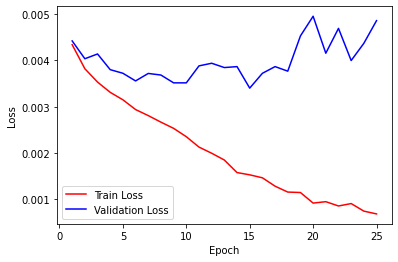

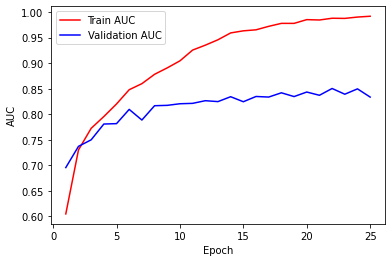

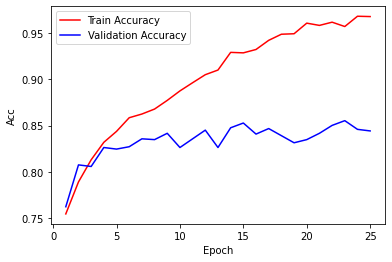

In [18]:
###############################
###        PERFORMANCE      ###
###############################

epoch = np.arange(1,len(train_losses)+1)
plt.figure()
plt.plot(epoch, train_losses, 'r', epoch, valid_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

epoch = np.arange(1,len(train_auc)+1)
plt.figure()
plt.plot(epoch, train_auc, 'r', epoch, valid_auc, 'b')
plt.legend(['Train AUC','Validation AUC'])
plt.xlabel('Epoch'), plt.ylabel('AUC')

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')

#print("Train accuracy:", train_acc, sep = "\n")
#print("Validation accuracy:", valid_acc, sep = "\n")


In [ ]:
print('Training Classification Report')
print(classification_report(train_targs, train_preds))

In [ ]:
print('Validation Classification Report')
print(classification_report(val_targs, val_preds))

Text(0.5, 1.0, 'Validation AUC')

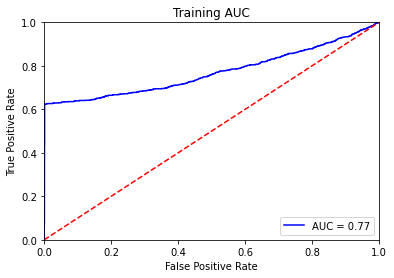

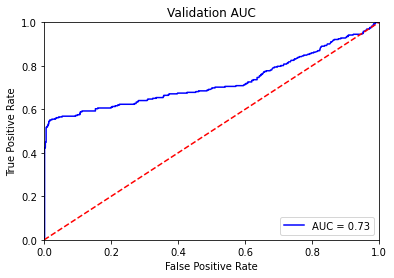

In [136]:
plot_roc(train_targs, train_probs)
plt.title("Training AUC")
plot_roc(val_targs, val_probs)
plt.title("Validation AUC")